# Problem 1: Importance of likelihood selection.
Consider an experimental setup where we can present an N-dimensional stimulus x ∈ RN that elicits a response in a recorded neural population. For one of these neurons, assume that we measure a response r(x) for a neuron with a tuning curve g that is defined as the number of spikes in 1 s after the presentation of the stimulus. A common model for the response distribution of this neuron is the Poisson model where the response r is distributed as P(r|x) = Poisson(e^⟨g,x⟩) where ⟨g,x⟩ denotes the inner product between two vectors.

##Part D
Adding in priors: Now let’s add some prior knowledge about the tuning curve. For the Gaussian case, add a Gaussian prior p(g) ∼ N(0,σ2I). Recall that with priors we change from a maximum likelihood to a maximum a-posteriori (MAP) estimation. Use the definition of the MAP estimate and Bayes rule to derive the estimator. How does this change the optimization? How about the estimated tuning curve? For the Poisson case, add a “smoothing” term p(∇g) ∼N(0,σ2I) (following the same procedure). How does this affect the optimization? How about the estimated tuning curve?

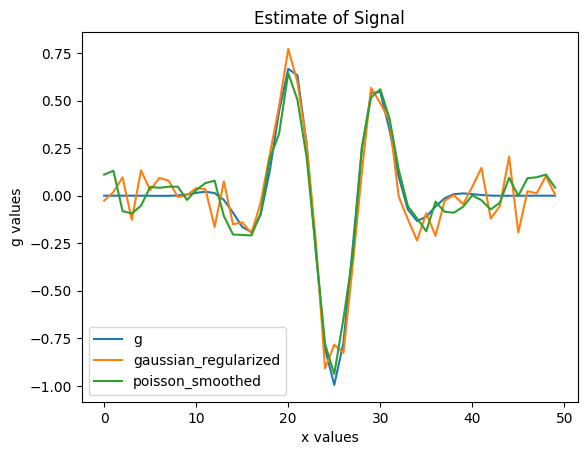

In [ ]:
from numpy import random
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
from scipy.stats import poisson
import numpy as np
import math

N = 50
M = 400
cos_vals = np.linspace(0, N-1, N) / 10
g = scipy.signal.windows.gaussian(N, std=5.0) * np.cos(2 * math.pi * cos_vals)

# Generate samples
X = []
for i in range(M):
  X.append(2 * random.uniform(size=N))
X = np.array(X)
g = np.array(g)
inner_product = np.matmul(X, g)

## Gaussian Case
# Generate the response vector r with Gaussian noise / model, apply a gaussian prior -> regularized least squares
# Set noise standard deviation
sigma = 1
noise = np.random.normal(0, sigma, M)
r_gauss = inner_product + noise

# Solve for Gaussian estimate
# Negative log-likelihood with Gaussian prior
def gaussian_log_likelihood_with_prior(g, X, r, sigma, sigma_prior):
    residual = r - np.dot(X, g)
    likelihood_term = 0.5 * np.sum((residual / sigma) ** 2)
    prior_term = 0.5 * np.sum((g / sigma_prior) ** 2)
    return likelihood_term + prior_term

g_initial = np.zeros(X.shape[1])
g_gaussian_estimate = optimize.minimize(gaussian_log_likelihood_with_prior, g_initial, args=(X, r_gauss, sigma, 1), method='L-BFGS-B').x

## Poisson Case
# Generate response vector r assuming Poisson Likelihood with smoothing term, same case
r_poisson = random.poisson(np.exp(np.matmul(X, g)))

# Solve for Poisson estimate
def estimate_g(g, X, r_poisson):
  lambda_reg = 16
  mean_response = np.exp(np.dot(X, g))
  return -np.sum(r_poisson * np.log(mean_response + 1e-10) - mean_response) + lambda_reg * np.abs(np.sum(np.square(np.diff(g))))

g_initial = np.zeros(X.shape[1])
poisson_estimate = optimize.minimize(estimate_g, g_initial, args=(X, r_poisson), method='L-BFGS-B').x # Alternative to fminunc

# Plotting
plt.figure()
plt.plot(g, label="g")
plt.plot(g_gaussian_estimate, label="gaussian_regularized")
plt.plot(poisson_estimate, label="poisson_smoothed")
plt.xlabel('x values')
plt.ylabel('g values')
plt.title('Estimate of Signal')
plt.legend()

Adding the prior to the gaussian estimate (by assuming a gaussian prior) essentially adds a regularization term to solving the loss function between the estimate the gaussian g and the real g based on the data. The tuning curve thus gets regularized to avoid large changes in variance and matching too well with the data points given. On the other hand, adding a smoothing term to the poisson case changes the optimization by adding a penalty parameter that reflects the poorly if the difference between values in the poisson estimate are too different from each other. Overall, the tunning curve is thus smoother and less jagged.